**1.Install the following packages**

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install emot
!pip install num2words
!pip install nltk
!pip install sklearn
!pip install wordcloud

     |████████████████████████████████| 102kB 8.4MB/s 


**2.Import the following libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive
import re
from emot.emo_unicode import UNICODE_EMO, EMOTICONS
from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import sklearn.metrics as metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix,precision_score,recall_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from wordcloud import WordCloud
from keras.layers import Embedding,Dense,SimpleRNN,Dropout
from keras.preprocessing import sequence
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**3.Mount Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls 'drive/MyDrive/Covid-19-Dataset'

Constraint_English_Test.xlsx   Constraint_English_Val.xlsx
Constraint_English_Train.xlsx  english_test_with_labels.xlsx


**4.LOAD AND VISUALISE DATA**

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/Covid-19-Dataset/Constraint_English_Train.xlsx')
val_data = pd.read_excel('/content/drive/MyDrive/Covid-19-Dataset/Constraint_English_Val.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/Covid-19-Dataset/english_test_with_labels.xlsx')

In [ ]:
def visualise_data(data):
  print("*****Data Information*****")
  print(data.info())
  fig = plt.figure(figsize = (10, 5)) 
  xvalues = ['fake', 'real']
  df = data.groupby('label')['id'].nunique()
  cnt1 = df['real']
  cnt0 = df['fake']
  print("FAKE : ",cnt0)
  print("REAL : ",cnt1)
  yvalues = [cnt0, cnt1]
  plt.bar(xvalues, yvalues, color ='orange', width = 0.4) 
  plt.xlabel("Tweet Labels") 
  plt.ylabel("Count") 
  plt.title("*****ANALYSIS OF TWEETS*****") 
  plt.show() 

*****Data Information*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      6420 non-null   int64 
 1   tweet   6420 non-null   object
 2   label   6420 non-null   object
dtypes: int64(1), object(2)
memory usage: 150.6+ KB
None
FAKE :  3060
REAL :  3360


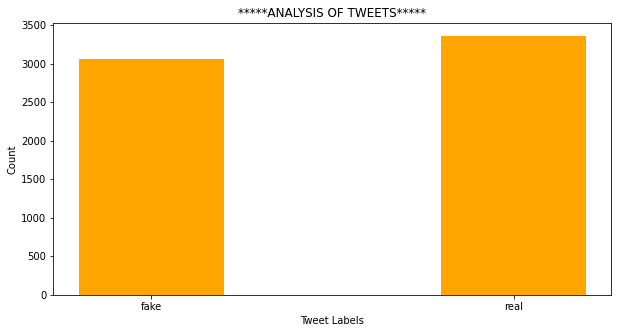

In [ ]:
visualise_data(train_data)

*****Data Information*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB
None
FAKE :  1020
REAL :  1120


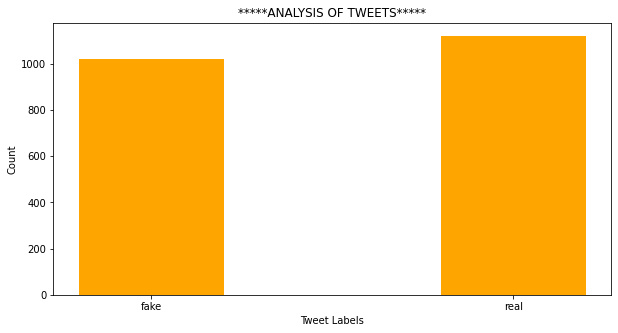

In [ ]:
visualise_data(val_data)

*****Data Information*****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2140 entries, 0 to 2139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2140 non-null   int64 
 1   tweet   2140 non-null   object
 2   label   2140 non-null   object
dtypes: int64(1), object(2)
memory usage: 50.3+ KB
None
FAKE :  1020
REAL :  1120


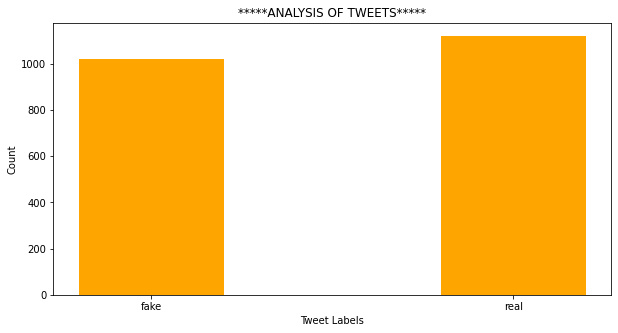

In [ ]:
visualise_data(test_data)

In [ ]:
train_data = train_data.append(val_data)
train_data = train_data.values
np.random.shuffle(train_data)
test_data = test_data.values
np.random.shuffle(test_data)

**5.DATA PRE-PROCESSING**

In [ ]:
lmt = WordNetLemmatizer()

def links_removal(sentence):
  sentence = re.sub(r"http(\S)+",' ',sentence)  
  return sentence

def convert_emoji_text(sentence):
  for emoji in UNICODE_EMO:
    sentence = sentence.replace(emoji, " ".join(UNICODE_EMO[emoji].replace(",","").replace(":","").split()))
  return sentence

def convert_numbers_text(sentence):
  sentence = ' '.join([num2words(i) if i.isdigit() else i for i in sentence.split()])
  return sentence  

def remove_special(sentence):
  sentence = ' '.join([word[1:] if word[0]=='#' else word for word in sentence.split()])
  sentence = ' '.join([word[0:-1] if word[-1]=='⁰' else word for word in sentence.split()])
  sentence = ' '.join([' ' if word[0]=='@' else word for word in sentence.split()])
  return sentence

def punctuation_removal(sentence):
  sentence = re.sub(r"[^\w\s]",' ',sentence)
  return sentence

def lematize(sentence):
  sentence = ' '.join([lmt.lemmatize(word) for word in sentence.split()])
  return sentence

In [ ]:
def preprocess(data):
  print("PreProcessing Started")
  for i in range(data.shape[0]):
    tweet = data[i,1]
    tweet = links_removal(tweet)
    tweet = remove_special(tweet)
    tweet = punctuation_removal(tweet)
    tweet = convert_emoji_text(tweet)
    tweet = convert_numbers_text(tweet)
    tweet = lematize(tweet)
    data[i,1] = tweet
  print("PreProcessing Completed")

preprocess(train_data)
preprocess(test_data)

PreProcessing Started
PreProcessing Completed
PreProcessing Started
PreProcessing Completed


**SPLIT TRAIN AND TEST DATA INTO X AND y**

In [ ]:
X_train = train_data[:,1]
Y_train = train_data[:,2]
X_test = test_data[:,1]
Y_test = test_data[:,2]

In [ ]:
def gen_wordcloud(X_train, Y_train, type_tweet):
  tokens = ""
  for i in range(X_train.shape[0]):
    tweet = X_train[i]
    if Y_train[i]==type_tweet:
      tokens += tweet + " "

  wordcloud = WordCloud(width = 600, height = 400, 
              background_color ='black',  
              min_font_size = 10).generate(tokens) 
                       
  plt.figure(figsize = (6, 6), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  plt.show()

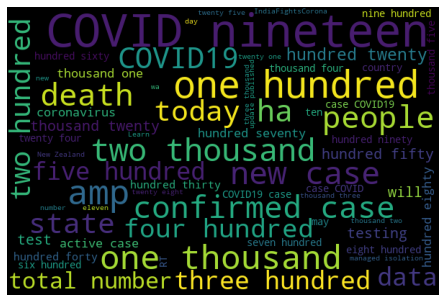

In [ ]:
gen_wordcloud(X_train, Y_train, "real")

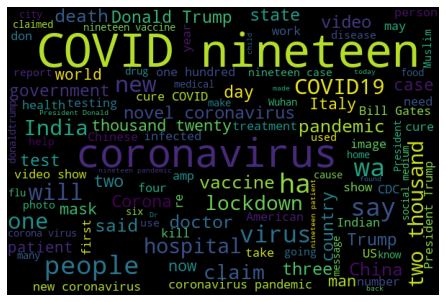

In [ ]:
gen_wordcloud(X_train, Y_train, "fake")

**FUNCTION TO PRINT METRICS FROM PREDICTED AND ACTUAL LABELS**

In [ ]:
def print_metrices(Y_pred,Y_test):
    cm = confusion_matrix(Y_test,Y_pred)
    print(cm)
    class_names = ['Fake','Real']
    sns.heatmap(cm,annot = True,xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
    plt.show()
    print(classification_report(Y_test,Y_pred,))
    print("Accuracy : ",accuracy_score(Y_pred,Y_test))
    print("Precison : ",precision_score(Y_pred,Y_test, average = 'weighted'))
    print("Recall : ",recall_score(Y_pred,Y_test,  average = 'weighted'))
    print("F1 : ",f1_score(Y_pred,Y_test,  average = 'weighted'))

def build_roc_auc(Y_test, Y_pred):
    Y_test = [0 if Y_test[i]=="fake" else 1 for i in range(Y_test.shape[0])]
    Y_pred = [0 if Y_pred[i]=="fake" else 1 for i in range(Y_pred.shape[0])]
    fpr,tpr,threshold = metrics.roc_curve(Y_test, Y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('GAR')
    plt.xlabel('FAR')
    plt.show()

**LOGISTIC REGRESSION(LR)**


*****Logistic Regression I*****

[[ 963   57]
 [  77 1043]]


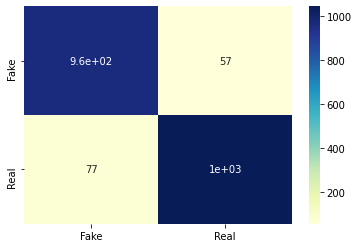

              precision    recall  f1-score   support

        fake       0.93      0.94      0.93      1020
        real       0.95      0.93      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9373831775700935
Precison :  0.9375034359538208
Recall :  0.9373831775700935
F1 :  0.93736127017136


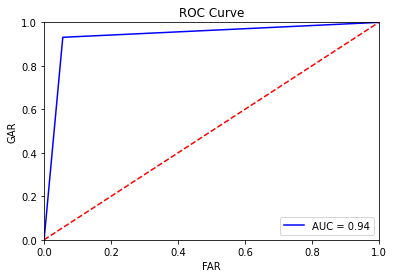

In [ ]:
print('\n*****Logistic Regression I*****\n')
pipe_lr1 = Pipeline([
              ('bow', CountVectorizer()),    
              ('lr_clf', LogisticRegression(max_iter=1000))
          ])

fit = pipe_lr1.fit(X_train,Y_train)
Y_pred1 = pipe_lr1.predict(X_test)
print_metrices(Y_pred1,Y_test) 
build_roc_auc(Y_test, Y_pred1)


*****Logistic Regression II*****

[[ 947   73]
 [  93 1027]]


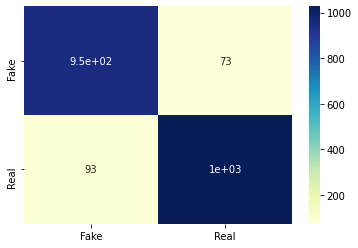

              precision    recall  f1-score   support

        fake       0.91      0.93      0.92      1020
        real       0.93      0.92      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140

Accuracy :  0.922429906542056
Precison :  0.9225370755778947
Recall :  0.922429906542056
F1 :  0.9224027675257146


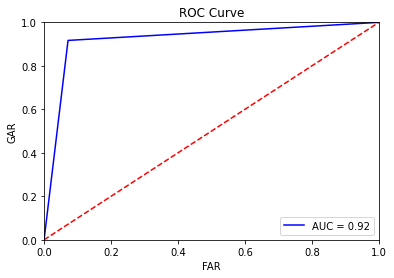

In [ ]:
print('\n*****Logistic Regression II*****\n')
pipe_lr2 = Pipeline([
              ('bow', CountVectorizer()),  
              ('tfidf', TfidfTransformer()),  
              ('lr_clf', LogisticRegression(max_iter=1000))
          ])

fit = pipe_lr2.fit(X_train,Y_train)
Y_pred2 = pipe_lr2.predict(X_test)
print_metrices(Y_pred2, Y_test) 
build_roc_auc(Y_test, Y_pred2)

**SUPPORT VECTOR MACHINE(SVM)**


*****Support Vector Machine I*****

[[ 941   79]
 [  81 1039]]


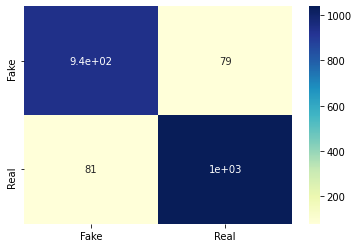

              precision    recall  f1-score   support

        fake       0.92      0.92      0.92      1020
        real       0.93      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140

Accuracy :  0.9252336448598131
Precison :  0.9252288508861488
Recall :  0.9252336448598131
F1 :  0.9252304382474643


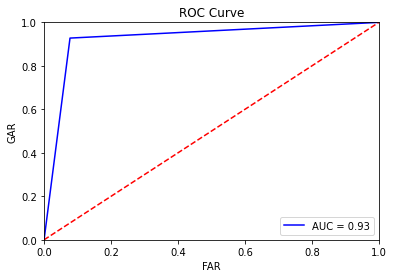

In [ ]:
print('\n*****Support Vector Machine I*****\n')
pipe_svm1 = Pipeline([
              ('bow', CountVectorizer()),    
              ('svm_clf', LinearSVC(max_iter=1000))
           ])

fit = pipe_svm1.fit(X_train,Y_train)
Y_pred1 = pipe_svm1.predict(X_test)
print_metrices(Y_pred1,Y_test)
build_roc_auc(Y_test, Y_pred1)


*****Support Vector Machine II*****

[[ 956   64]
 [  62 1058]]


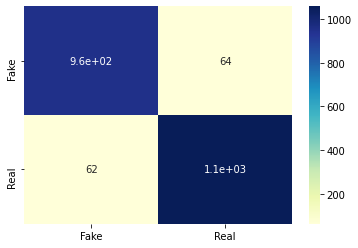

              precision    recall  f1-score   support

        fake       0.94      0.94      0.94      1020
        real       0.94      0.94      0.94      1120

    accuracy                           0.94      2140
   macro avg       0.94      0.94      0.94      2140
weighted avg       0.94      0.94      0.94      2140

Accuracy :  0.9411214953271028
Precison :  0.9411283999581141
Recall :  0.9411214953271028
F1 :  0.9411241240641833


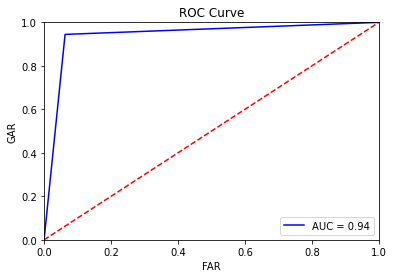

In [ ]:
print('\n*****Support Vector Machine II*****\n')
pipe_svm2 = Pipeline([
              ('bow', CountVectorizer()),  
              ('tfidf', TfidfTransformer()),  
              ('svm_clf', LinearSVC(max_iter=1000))
           ])

fit = pipe_svm2.fit(X_train,Y_train)
Y_pred2 = pipe_svm2.predict(X_test)
print_metrices(Y_pred2,Y_test)
build_roc_auc(Y_test, Y_pred2)

**DECISION TREE(DT)**


*****Decision Tree I*****

[[873 147]
 [145 975]]


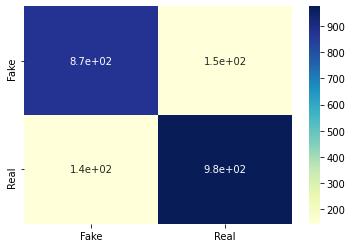

              precision    recall  f1-score   support

        fake       0.86      0.86      0.86      1020
        real       0.87      0.87      0.87      1120

    accuracy                           0.86      2140
   macro avg       0.86      0.86      0.86      2140
weighted avg       0.86      0.86      0.86      2140

Accuracy :  0.8635514018691589
Precison :  0.8635650965993874
Recall :  0.8635514018691589
F1 :  0.8635574938630279


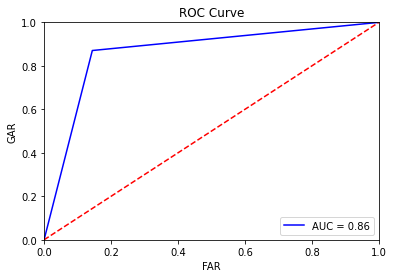

In [ ]:
print('\n*****Decision Tree I*****\n')
pipe_dt1 = Pipeline([
              ('bow', CountVectorizer()),   
              ('dt_clf', tree.DecisionTreeClassifier(splitter="random"))
          ])
fit = pipe_dt1.fit(X_train, Y_train)
Y_pred1 = pipe_dt1.predict(X_test)
print_metrices(Y_pred1,Y_test)
build_roc_auc(Y_test, Y_pred1)


*****Decision Tree II*****

[[866 154]
 [158 962]]


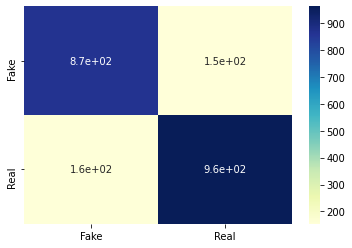

              precision    recall  f1-score   support

        fake       0.85      0.85      0.85      1020
        real       0.86      0.86      0.86      1120

    accuracy                           0.85      2140
   macro avg       0.85      0.85      0.85      2140
weighted avg       0.85      0.85      0.85      2140

Accuracy :  0.8542056074766355
Precison :  0.8541870860493731
Recall :  0.8542056074766355
F1 :  0.8541933579486464


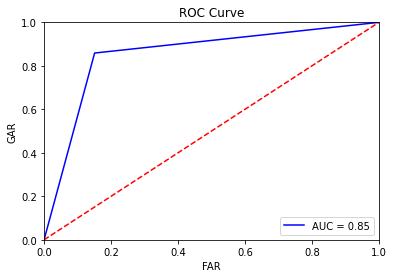

In [ ]:
print('\n*****Decision Tree II*****\n')
pipe_dt2 = Pipeline([
              ('bow', CountVectorizer()),  
              ('tfidf', TfidfTransformer()),  
              ('dt_clf', tree.DecisionTreeClassifier(splitter="random"))
          ])
fit = pipe_dt2.fit(X_train, Y_train)
Y_pred2 = pipe_dt2.predict(X_test)
print_metrices(Y_pred2,Y_test)
build_roc_auc(Y_test, Y_pred2)

**Random Forest Classifier (RF)**


*****Random Forest I*****

[[ 938   82]
 [ 113 1007]]


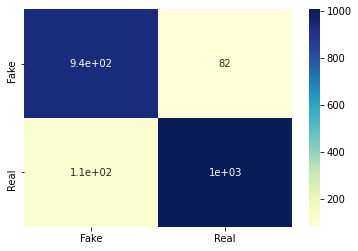

              precision    recall  f1-score   support

        fake       0.89      0.92      0.91      1020
        real       0.92      0.90      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.91      0.91      0.91      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9088785046728972
Precison :  0.9091754774339642
Recall :  0.9088785046728972
F1 :  0.9088359001400372


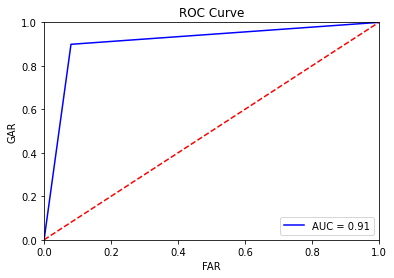

In [ ]:
print('\n*****Random Forest I*****\n')
pipe_rf1 = Pipeline([
              ('bow', CountVectorizer()),  
              ('rf_clf', RandomForestClassifier())
          ])
fit = pipe_rf1.fit(X_train, Y_train)
Y_pred1 = pipe_rf1.predict(X_test)
print_metrices(Y_pred1,Y_test)
build_roc_auc(Y_test, Y_pred1)


*****Random Forest II*****

[[ 925   95]
 [ 108 1012]]


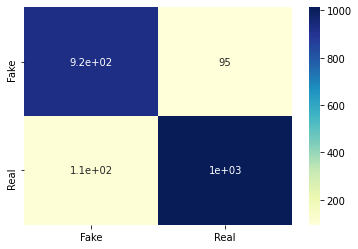

              precision    recall  f1-score   support

        fake       0.90      0.91      0.90      1020
        real       0.91      0.90      0.91      1120

    accuracy                           0.91      2140
   macro avg       0.90      0.91      0.90      2140
weighted avg       0.91      0.91      0.91      2140

Accuracy :  0.9051401869158878
Precison :  0.9051601808947878
Recall :  0.9051401869158878
F1 :  0.9051167210976119


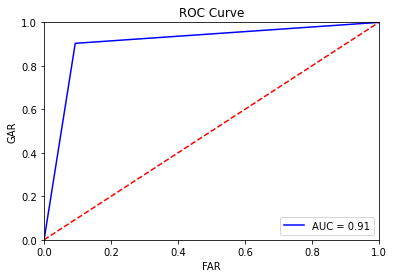

In [ ]:
print('\n*****Random Forest II*****\n')
pipe_rf2 = Pipeline([
              ('bow', CountVectorizer()),  
              ('tfidf', TfidfTransformer()),  
              ('rf_clf', RandomForestClassifier())
          ])
fit = pipe_rf2.fit(X_train, Y_train)
Y_pred2 = pipe_rf2.predict(X_test)
print_metrices(Y_pred2,Y_test)
build_roc_auc(Y_test, Y_pred2)

**Reccurent Neural Networks (RNN)**

In [ ]:
class RNN_Covid:
  def __init__(self, X_train, Y_train, X_test, Y_test):
    self.X_train = X_train 
    self.X_test = X_test
    self.Y_train = Y_train
    self.Y_test = Y_test 
    self.word_dict = {}
  
  def create_word_dict(self, data):
    label_num = 1
    info_num = 1
    for info in data:
        broken_info = info.split(' ')
        for word in broken_info:
            word = word.lower()
            if word in self.word_dict.keys():
                continue
            else:
                self.word_dict[word] = label_num
                label_num += 1
        info_num += 1
    print("Word Dictionary Updated")
    print("Total Words Present Now are : ", str(len(self.word_dict)))
  
  def modify_train_dataset(self):
    for i in range(self.X_train.shape[0]):
      broken_info = self.X_train[i].split(' ')
      broken_info = np.array(broken_info)
      modified_info = np.zeros(broken_info.shape,dtype='int')
      j = 0
      for word in broken_info:
          word = word.lower()
          modified_info[j] = self.word_dict[word]
          j += 1
      self.X_train[i] = modified_info
      if self.Y_train[i]=="fake":
        self.Y_train[i] = 0
      else:
        self.Y_train[i] = 1

  def modify_test_dataset(self):
    for i in range(self.X_test.shape[0]):
      broken_info = self.X_test[i].split(' ')
      broken_info = np.array(broken_info)
      modified_info = np.zeros(broken_info.shape,dtype='int')
      j = 0
      for word in broken_info:
          word = word.lower()
          modified_info[j] = self.word_dict[word]
          j += 1
      self.X_test[i] = modified_info
      if self.Y_test[i]=="fake":
        self.Y_test[i] = 0
      else:
        self.Y_test[i] = 1

  def train_util(self):
    max_len = 0
    for i in range(self.X_train.shape[0]):
      self.X_train[i] = self.X_train[i].tolist()
      max_len = max(max_len,len(self.X_train[i]))
    print(max_len)
    self.Y_train = self.Y_train.tolist()
  
  def test_util(self):
    max_len = 0
    for i in range(self.X_test.shape[0]):
      self.X_test[i] = self.X_test[i].tolist()
      max_len = max(max_len,len(self.X_test[i]))
    print(max_len)
    self.Y_test = self.Y_test.tolist()
  
  def create_model(self, epoch, bsize, opt, l, met):
    self.X_train = sequence.pad_sequences(self.X_train, maxlen=300)
    self.X_test = sequence.pad_sequences(self.X_test, maxlen=300)

    self.X_train = np.array(self.X_train)
    self.Y_train = np.array(self.Y_train)
    self.X_test = np.array(self.X_test)
    self.Y_test = np.array(self.Y_test)
  
    self.model = Sequential()
    self.model.add(Embedding(len(self.word_dict),100))
    self.model.add(SimpleRNN(64))
    self.model.add(Dense(80,activation='relu'))
    self.model.add(Dropout(0.25))
    self.model.add(Dense(10,activation='sigmoid'))
    self.model.add(Dropout(0.2))
    self.model.add(Dense(1,activation='sigmoid'))
    print(self.model.summary())

    self.model.compile(optimizer=opt,loss=l,metrics=met)

    self.hist = self.model.fit(self.X_train,self.Y_train,batch_size=bsize,epochs=epoch,validation_split=0.2,shuffle=True)

  def plot_curves(self):
    fig, ax = plt.subplots(1, 2)
    print("\n************Accuracy & Loss Plots************\n")

    ax[0].plot(self.hist.history['loss'], label="Loss")
    ax[0].plot(self.hist.history['accuracy'],label="Accuracy")
    ax[0].legend()

    ax[1].plot(self.hist.history['val_loss'], label="Val_Loss")
    ax[1].plot(self.hist.history['val_accuracy'],label="Val_Accuracy")
    ax[1].legend()

    fig.show()
  
  def evaluate_model(self):
    print("\n**********************TRAINING**********************")
    sc = self.model.evaluate(self.X_train, self.Y_train) 
    print(sc)
    print("\n**********************TESTING**********************")
    sc = self.model.evaluate(self.X_test, self.Y_test) 
    print(sc)
    print("\n")

  def train_model(self, epochs=10, batch_size=128, optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy']):
    self.create_word_dict(self.X_train)
    self.create_word_dict(self.X_test)
    self.modify_train_dataset()
    self.modify_test_dataset()
    self.train_util()
    self.test_util()
    self.create_model(epochs, batch_size, optimizer, loss, metrics)


Word Dictionary Updated
Total Words Present Now are :  12968
Word Dictionary Updated
Total Words Present Now are :  14367
1514
1475
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1436700   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                10560     
_________________________________________________________________
dense_3 (Dense)              (None, 80)                5200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                810       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)               

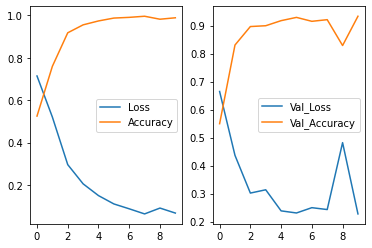

In [ ]:
rnn_covid = RNN_Covid(X_train, Y_train, X_test, Y_test)
rnn_covid.train_model()
rnn_covid.evaluate_model()
rnn_covid.plot_curves()